# Project 3: Real word data
- Explore the data.
- Train at least three different regression models and cross-validate them with MSE and R2-score.
- Try out pre-processing techniques.
- Choose two types of feature selection and implement at least one method for each.
Experimentally evaluate your feature selections.
- For the best performing combination of model and pre-processing steps, implement and plot the so-called learning curve
on your own.

,Count,Shape,Min,Max,Mean,Std
X,1000,"(1000, 2)","[-19.0, -14.0]","[20.0, 21.0]","[5.0, 6.0]","[7.0, 7.0]"
y,1000,"(1000,)",0,1,1,0


Class 0 sample count: 150
Class 1 sample count: 850


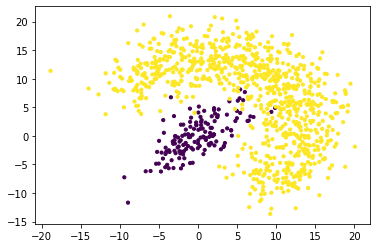

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# TODO: load dataset 1
data_set = np.load('dataset_1.npz')

# generic function to extract named properties from the data set items
# fs is a list of tuples, first a name, then a function mapping an item to a property
def property_table(fs, data_set):
    keys = list(data_set.keys()) # row names
    props = list(map(lambda f: f[0], fs)) # column names
    funcs = list(map(lambda f: f[1], fs)) # property functions
    items = list(map(lambda t: t[1], data_set.items())) # data items
    data = zip(*list(map(lambda f: map(f, items), funcs))) # each prop for each item
    df = pd.DataFrame(data, index=keys, columns=props) # use pandas.DataFrame to print a table
    display(df)
    
def dataset_info(ds):
    property_table([
        ('Count', lambda item: len(item)),
        ('Shape', lambda item: item.shape),
        ('Min', lambda item: np.round(np.amin(item, axis=0))),
        ('Max', lambda item: np.round(np.amax(item, axis=0))),
        ('Mean', lambda item: np.round(np.mean(item, axis=0))),
        ('Std', lambda item: np.round(np.std(item, axis=0))),
    ], ds)
    
dataset_info(data_set)


X = data_set['X']
y = data_set['y']
           
def class_counts(y):
    c = max(list(y)) + 1
    for i in range(0, c):
        print(f"Class {i} sample count: {len(list(filter(lambda x: x == i, y)))}")

class_counts(y)
plt.scatter(*zip(*X), s=10.0, c=y)


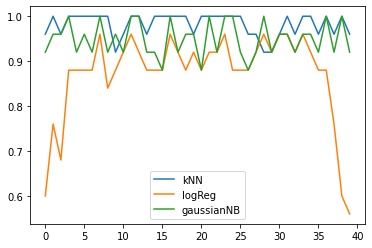

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# TODO: train a kNN, Logistic Regression, and a Naive Bayes classifier on the dataset. Report the accuracies.

CROSS_VAL_FOLDS=40

# train and score classifier using cross validation
def score(name, clf, data, y):
    scores = cross_val_score(clf, data, y, cv=CROSS_VAL_FOLDS)
    #print(f'{name}_scores = {scores}')
    plt.plot(scores, label=name)
            
# score a list of classifiers
def score_all(clfs, data, y):
    for (name, clf) in clfs:
        score(name, clf, data, y)
    plt.legend()

kNN = KNeighborsClassifier(5)
logReg = LogisticRegression()
gaussianNB = GaussianNB()

clfs = [
    ("kNN", kNN),
    ("logReg", logReg),
    ("gaussianNB", gaussianNB)
]
score_all(clfs, X, y)


In [27]:
# TODO: analyze the dataset; focus on possible reasons for why you might want to apply the metrics described above
# 1) Balance between classes
class_count = np.zeros(max(y) + 1, np.int64)
for i in range(0, len(y)):
    class_count[y[i]] = class_count[y[i]] + 1

for i in range (0, len(class_count)):
    print('number instances class_' + str(i) + ': ' + str(class_count[i]))

# 2) Shape of the data set X
print('Shape of X: ' + str(X.shape))

number instances class_0: 150
number instances class_1: 850
Shape of X: (1000, 2)


In [28]:
# TODO: reevalute your trained models with the metrics you described above.
# Visualize the confusion matrices for all classifiers

from sklearn.metrics import confusion_matrix

kNN = KNeighborsClassifier(5)
kNN_scores = cross_val_score(kNN, X, y, cv=10, scoring='precision')

logReg = LogisticRegression()
logReg_scores = cross_val_score(logReg, X, y, cv=10, scoring='precision')

gaussianNB = GaussianNB()
gaussianNB_scores = cross_val_score(gaussianNB, X, y, cv=10, scoring='precision')

print('kNN_scores precision= ' + str(kNN_scores))
print('logReg_scores precision= ' + str(logReg_scores))
print('gaussianNB_scores precision= ' + str(gaussianNB_scores))

kNN_scores precision= [0.97647059 1.         1.         0.98837209 1.         0.98837209
 0.98823529 0.97647059 0.98823529 0.98823529]
logReg_scores precision= [0.88888889 0.90217391 0.89473684 0.89473684 0.91397849 0.90425532
 0.89473684 0.92391304 0.93103448 0.775     ]
gaussianNB_scores precision= [0.96511628 0.96590909 0.94444444 0.95505618 0.92391304 0.94444444
 0.95505618 0.93406593 0.94444444 0.93406593]


In [29]:
kNN = KNeighborsClassifier(5)
kNN_scores = cross_val_score(kNN, X, y, cv=10, scoring='recall')

logReg = LogisticRegression()
logReg_scores = cross_val_score(logReg, X, y, cv=10, scoring='recall')

gaussianNB = GaussianNB()
gaussianNB_scores = cross_val_score(gaussianNB, X, y, cv=10, scoring='recall')

print('kNN_scores recall= ' + str(kNN_scores))
print('logReg_scores recall= ' + str(logReg_scores))
print('gaussianNB_scores recall= ' + str(gaussianNB_scores))

kNN_scores recall= [0.97647059 1.         0.95294118 1.         1.         1.
 0.98823529 0.97647059 0.98823529 0.98823529]
logReg_scores recall= [0.37647059 0.97647059 1.         1.         1.         1.
 1.         1.         0.95294118 0.36470588]
gaussianNB_scores recall= [0.97647059 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


In [30]:
kNN = KNeighborsClassifier(5)
kNN_scores = cross_val_score(kNN, X, y, cv=10, scoring='f1')

logReg = LogisticRegression()
logReg_scores = cross_val_score(logReg, X, y, cv=10, scoring='f1')

gaussianNB = GaussianNB()
gaussianNB_scores = cross_val_score(gaussianNB, X, y, cv=10, scoring='f1')

print('kNN_scores f1= ' + str(kNN_scores))
print('logReg_scores f1= ' + str(logReg_scores))
print('gaussianNB_scores f1= ' + str(gaussianNB_scores))

kNN_scores f1= [0.97647059 1.         0.97590361 0.99415205 1.         0.99415205
 0.98823529 0.97647059 0.98823529 0.98823529]
logReg_scores f1= [0.52892562 0.93785311 0.94444444 0.94444444 0.95505618 0.94972067
 0.94444444 0.96045198 0.94186047 0.496     ]
gaussianNB_scores f1= [0.97076023 0.98265896 0.97142857 0.97701149 0.96045198 0.97142857
 0.97701149 0.96590909 0.97142857 0.96590909]


kNN_scores roc_auc= [0.99686275 1.         0.99607843 1.         1.         0.99960784
 0.96509804 0.99137255 0.99529412 0.99137255]
logReg_scores roc_auc= [0.59921569 0.90352941 0.98196078 0.99843137 1.         0.99843137
 1.         0.92862745 0.8        0.34431373]
gaussianNB_scores roc_auc= [0.96862745 0.99764706 0.99372549 1.         1.         1.
 1.         0.97411765 0.95137255 0.91607843]


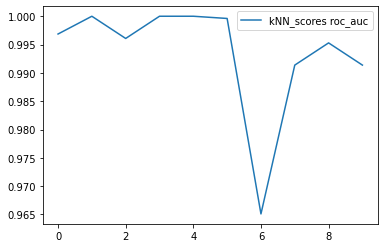

In [36]:
kNN = KNeighborsClassifier(5)
kNN_scores = cross_val_score(kNN, X, y, cv=10, scoring='roc_auc')

logReg = LogisticRegression()
logReg_scores = cross_val_score(logReg, X, y, cv=10, scoring='roc_auc')

gaussianNB = GaussianNB()
gaussianNB_scores = cross_val_score(gaussianNB, X, y, cv=10, scoring='roc_auc')

print('kNN_scores roc_auc= ' + str(kNN_scores))
plt.plot(kNN_scores, label="kNN_scores roc_auc")
plt.legend()
print('logReg_scores roc_auc= ' + str(logReg_scores))
print('gaussianNB_scores roc_auc= ' + str(gaussianNB_scores))

In [32]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

kNN = KNeighborsClassifier(5)
kNN_predict = cross_val_predict(kNN, X, y, cv=10)
kNN_confusion_matrix = confusion_matrix(y, kNN_predict)

logReg = LogisticRegression()
logReg_predict = cross_val_predict(logReg, X, y, cv=10)
logReg_confusion_matrix = confusion_matrix(y, logReg_predict)

gaussianNB = GaussianNB()
gaussianNB_predict = cross_val_predict(gaussianNB, X, y, cv=10)
gaussianNB_confusion_matrix = confusion_matrix(y, gaussianNB_predict)

print('kNN_scores confusion matrix= ' + str(kNN_confusion_matrix))
print('logReg_scores confusion matrix= ' + str(logReg_confusion_matrix))
print('gaussianNB_scores confusion matrix= ' + str(gaussianNB_confusion_matrix))


kNN_scores confusion matrix= [[141   9]
 [ 11 839]]
logReg_scores confusion matrix= [[ 68  82]
 [113 737]]
gaussianNB_scores confusion matrix= [[102  48]
 [  2 848]]


raw.mean() = [-1.66785369 -1.46791693  0.71401576  2.40657653  0.2238962  -1.19126005
  1.78061454]
raw.std() = [57.42951361 57.58557726 56.65656124  7.39527504 57.76060814  7.45143671
 58.64520968]


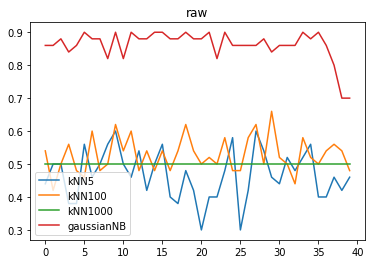

In [40]:
#TODO: Train all three classifiers on the second data set
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

def dist_info(name, data):
    print(f'{name}.mean() = {np.mean(data, axis=0)}')
    print(f'{name}.std() = {np.std(data, axis=0)}')

# test classifiers on an input
def test(clfs, name, data, y):
    dist_info(name, data)
    plt.title(name)
    #print(f'{name} = {data}')
    score_all(clfs, data, y)

# causes error with unscaled dataset
#score("logReg", logReg, X, y)

kNN5 = KNeighborsClassifier(5)
kNN100 = KNeighborsClassifier(100)
kNN1000 = KNeighborsClassifier(1000)
logReg = LogisticRegression()
gaussianNB = GaussianNB()
clfs_without_log = [
    ("kNN5", kNN5),
    ("kNN100", kNN100),
    ("kNN1000", kNN1000),
    ("gaussianNB", gaussianNB)
]
clfs = [
    *clfs_without_log,
    ("logReg", logReg),
]
test(clfs_without_log, "raw", X, y)

min_max.mean() = [0.49217359 0.49266428 0.50352962 0.46603852 0.50109592 0.49020206
 0.50912906]
min_max.std() = [0.28764025 0.28811128 0.2833488  0.20001988 0.28892953 0.1780207
 0.29338672]
robust.mean() = [-0.00812176  0.02078122  0.00759399  0.07346281 -0.00337467 -0.05339322
 -0.01594031]
robust.std() = [0.58251288 0.57134835 0.58321217 0.5986119  0.57939802 0.73859548
 0.56927511]


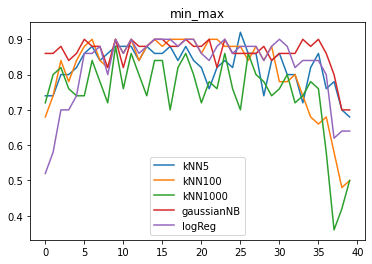

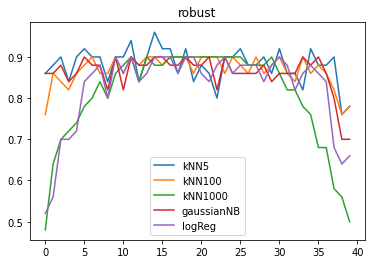

In [11]:
# test classifiers on a list of inputs
def test_all(clfs, data_list, y):
    for (i, (name, data)) in list(enumerate(data_list)):
        plt.figure(i)
        test(clfs, name, data, y)
        
def scale(data, scaler):
    return scaler.fit_transform(data)

# scale
min_max_scaled = scale(X, MinMaxScaler())
robust_scaled = scale(X, RobustScaler())

X_list = [
    ("min_max", min_max_scaled),
    ("robust", robust_scaled),
]
# test classifiers
test_all(clfs, X_list, y)


standardized.mean() = [ 2.79776202e-17 -1.11022302e-17  3.43657394e-17 -7.12763182e-16
 -4.60187444e-17  2.07611706e-17 -1.68615122e-17]
standardized.std() = [1. 1. 1. 1. 1. 1. 1.]


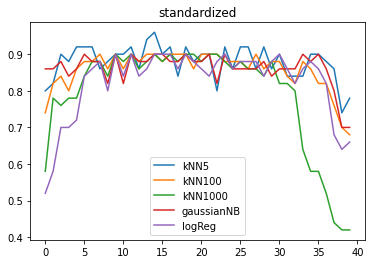

In [12]:
#TODO: Try this in practice,
#      retrain and test the models on the standardized dataset

standard = StandardScaler()
standard_scaled = scale(X, standard)
X_list = [
    ("standardized", standard_scaled),
]
test_all(clfs, X_list, y)

**TODO:** Analyze your results.

Using a standard scaler results in a dataset with near-zero mean and a variance of 1 for all features. The mean is not exactly zero due to limited floating-point precision, which means that the calculated mean of the original dataset may not exactly match its true mean. The error between the actual mean and the floating point representation is what causes the mean of the transformed dataset to not be exactly zero. But it is so close to zero that it is practically zero.

The scaling removed the varying variances between the features which allows the kNN classifier to make better predictions. Also logistic regression now converges, because the error for the decision boundary doesn't exceed a certain threshold anymore.

The gaussianNB classifier does not perform differently for different scalings, as this plot illustrates:

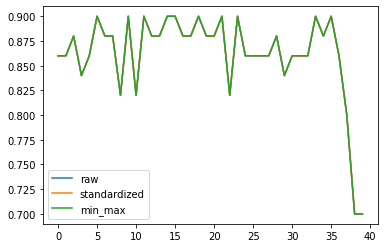

In [13]:
score("raw", gaussianNB, X, y)
score("standardized", gaussianNB, standard_scaled, y)
score("min_max", gaussianNB, min_max_scaled, y)
plt.legend()